# Notebook clustering

## 1. Import Libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn import set_config
from sklearn.cluster import KMeans
from sklearn.metrics import *
from sklearn.pipeline import *
from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import *
from sklearn.compose import (ColumnTransformer,
                             TransformedTargetRegressor,
                             make_column_transformer)
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import plotly.graph_objects as go
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import Birch
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
%load_ext pycodestyle_magic
%pycodestyle_on

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


## 2. Classes

### 2.1. Clustering

In [5]:
def preprocessig(X: pd.DataFrame):
    """Create proprocessor to preprocess numerical and categorical data.

    Args:
        X(pd.DataFrame) : data to preprocessed

    Returns:
        preprocessor(ColumnTransformer): proprocessing step to add to a pipeline
    """
    numeric_features = X.select_dtypes(include=[np.number]).columns
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="mean")),
               ("scaler", MinMaxScaler())]
    )

    categorical_features = X.select_dtypes(include=["object"]).columns
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="constant",
                                      fill_value="missing")),
            ("onehot", OneHotEncoder(handle_unknown="ignore",
                                     sparse=False)),
        ]
    )

    preprocessor = ColumnTransformer(
                        transformers=[
                            ("numeric", numeric_transformer,
                             numeric_features),
                            ("categorical", categorical_transformer,
                             categorical_features)
                        ]
                    )
    return preprocessor

In [15]:
class Clustering():
    def __init__(self, random_state=42):
        self.random_state = random_state

    def fit(self, X: pd.DataFrame, clusterings: List[dict]) -> list:
        """Cluster using several models.

        Args:
            X(pd.DataFrame): data to cluster
            clustering(List[dict]): list of models with their paramaters

        Returns:
            list: clustering labels
        """
        best_scores = dict()
        X_labels = pd.DataFrame()
        for cluster in clusterings:
            for name, info in cluster.items():
                silhouette_scores = []
                model = info['model']
                min = info['min']
                max = info['max']
                step = info['step']

                if name == 'DBSCAN':
                    for param in range(min, max + 1, step):
                        param = param / 10
                        pipe = Pipeline(steps=[("preprocessor", preprocessor),
                                               ("cluster", model(eps=param))])
                        pipe.fit(X)

                        score = silhouette_score(X, pipe['cluster'].labels_)
                        silhouette_scores.append(score)
                        print(f"For {name} model and {param},"
                              f"eps score is: {score}")

                        if np.array(silhouette_scores).max() == score:
                            labels = pipe['cluster'].labels_

                elif name == 'birch':
                    for param in range(min, max + 1, step):
                        pipe = Pipeline(steps=[("preprocessor", preprocessor),
                                               ("cluster",
                                                model(n_clusters=param))])
                        pipe.fit(X)

                        score = silhouette_score(X, pipe['cluster'].labels_)
                        silhouette_scores.append(score)
                        print(f"For {name} model and {param}",
                              f"clusters score is: {score}")

                        if np.array(silhouette_scores).max() == score:
                            labels = pipe['cluster'].labels_

                elif name == 'Kmeans':
                    kmeans_visualizer = Pipeline([
                        ("preprocessor", preprocessor),
                        ("kelbowvisualizer", KElbowVisualizer(model(),
                                                              K=(4, 12)))])
                    kmeans_visualizer.fit(X)
                    kmeans_visualizer.named_steps['kelbowvisualizer']\
                                     .show()

                    K = kmeans_visualizer.named_steps['kelbowvisualizer']\
                                         .elbow_value_

                    # Silhouette Visualizer
                    silhouette_visualizer = Pipeline([
                        ("preprocessor", preprocessor),
                        ("silhouettevisualizer",
                         SilhouetteVisualizer(KMeans(K)))])

                    silhouette_visualizer.fit(X)
                    silhouette_visualizer.named_steps['silhouettevisualizer']\
                                         .show()

                    labels = silhouette_visualizer\
                        .named_steps['silhouettevisualizer']\
                        .labels_

                    score = silhouette_visualizer\
                        .named_steps['silhouettevisualizer']\
                        .silhouette_score_
                    best_score = score

                    print(f"Best silhouette score for {name}",
                          f" model is {best_score}")

                    best_scores[name] = best_score

                    distance_visualizer = Pipeline([
                        ("preprocessor", preprocessor),
                        ("distancevisualizer",
                         InterclusterDistance(KMeans(K)))])
                    distance_visualizer.fit(X)
                    distance_visualizer.named_steps['distancevisualizer']\
                                       .show()

                X_labels[name+'_labels'] = labels

        return X_labels

    def data_scaler(self, data: pd.DataFrame) -> pd.DataFrame:
        """Normalize data.

        Args:
            data(pd.DataFrame): data to normalize

        Returns:
            pd.DataFrame: normalized data"""
        Sc = MinMaxScaler()
        return Sc.fit_transform(data)

    def two_dim_plot(self, X: pd.DataFrame, labels_data: list,
                     model: str = 'Kmeans', method: str = 'pca'):
        """Create a two dimensions plot to visualize clustering.

        Args:
            X(pd.DataFrame): data tahat have been clustered
            labels(list): cluestering labels
            model(str): model used for clustering
            method(str) method of 2D reduction"""

        data_scaled = self.data_scaler(X)

        if method == 'pca':
            pca = PCA(2)
            two_dim_data = pd.DataFrame(pca.fit_transform(data_scaled),
                                        columns=['var_1', 'var_2'])

            explain = pca.explained_variance_ratio_
            print(f"Explained variance ration for PCA is {explain.sum()}")

        if method == 'tsne':
            two_dim_data = pd.DataFrame(TSNE(n_components=2, perplexity=40)
                                        .fit_transform(data_scaled),
                                        columns=['var_1', 'var_2'])

        model_labels = X_labels.filter(like=model).columns.values[0]
        number_class = X_labels[model_labels].nunique()

        df = pd.concat([two_dim_data, X_labels], axis=1)

        plt.figure(figsize=(14, 10))
        sns.scatterplot(
            x="var_1", y="var_2",
            hue=model_labels,
            palette=sns.color_palette("hls", number_class),
            data=df,
            legend="full",
            alpha=0.3)

    def radar_plot(self, data: pd.DataFrame, data_labels: list, model: str):
        """Create radar plot to visualize clusters differences.

        Args:
             data(pd.DataFrame): data that have been clustered
             data_labels(list): clusters labels
             model(str): model that have been used for clustering"""

        data_scaled = self.data_scaler(data)
        data_scaled = pd.DataFrame(data_scaled, columns=X.columns.tolist())

        model_labels = data_labels.filter(like=model).columns.values[0]
        categories = data.columns.tolist()

        df = pd.concat([data_scaled, data_labels], axis=1)
        group_columns = df.groupby(model_labels)[categories].mean()\
                                                            .reset_index()

        fig = go.Figure()

        for idx, row in group_columns.iterrows():
            val = row[X.columns.tolist()].values
            group_name = row[model_labels]

            fig.add_trace(go.Scatterpolar(
                  r=val,
                  theta=categories,
                  fill='toself',
                  name=group_name))

        fig.update_layout(
            margin=dict(l=30, r=30, t=30, b=30)
        )

        fig.show()

    def insight(self, data: pd.DataFrame, data_labels: list, model: str):
        """Create DataFrame to visualize clusters differences.

        Args:
             data(pd.DataFrame): data that have been clustered
             data_labels(list): clusters labels
             model(str): model that have been used for clustering"""

        df = pd.concat([data, data_labels], axis=1)
        model_labels = data_labels.filter(like=model).columns.values[0]

        group = df.groupby(model_labels)[data.columns].describe()
        insight = group.style.background_gradient(cmap="RdPu")\
                       .set_properties(**{'font-size': '15px'})\
                       .format("{:.1f}")

        display(insight)

### 2.2. Parameters Tuning

In [16]:
class TuningClusters:
    def __init__(self, cluster, preprocessor,
                 search_space=None, random_state=42):
        self.cluster = cluster
        self.search_space = search_space
        self.name = cluster.__name__
        self.random_state = random_state
        self.preprocessor = preprocessor

    def hyperparameter_tuning(self, args: dict) -> dict:
        """Train model and calculate loss.

        Args:
            args(dict): agrs to use to train the model

        Returns: 
            dict: loss"""
        silhouette_visualizer = Pipeline([
                        ("preprocessor", preprocessor),
                        ("silhouettevisualizer",
                         SilhouetteVisualizer(KMeans(**args)))])
        silhouette_visualizer.fit(X)
        score = silhouette_visualizer\
            .named_steps['silhouettevisualizer']\
            .silhouette_score_
        return {'loss': -score, 'status': STATUS_OK}

    def optimisation(self):
        """Train several models to find the best hyperparameters."""
        best_params = {}
        if self.search_space : 
            trials = Trials()
            best_params = fmin(fn=self.hyperparameter_tuning,
                                space=self.search_space,
                                algo=tpe.suggest,
                                max_evals=10,
                                trials=trials, 
                                verbose=1, 
                                rstate=np.random.RandomState(self.random_state))
            best_params = space_eval(self.search_space, best_params)
            fnvals = [t['result']['loss'] for t in trials.trials]
            best_loss = min(fnvals)
            
        return best_params, best_loss
    
def benchmark(model_params: list, preprocessor) -> dict:
    """Run hyperopt."""
    params = {}
    losses = {}
    for cluster, search_params in models_params.items():
        best_params, best_loss = TuningClusters(cluster=cluster,
                                                search_space=search_params,
                                                preprocessor=preprocessor).optimisation()
        params[cluster.__name__] = best_params
        losses[cluster.__name__] = best_loss
    best_model = min(losses, key=losses.get)
    print(f'{best_model} is the best model with a loss of {losses[best_model]}')
    return params[best_model]

16:17: W291 trailing whitespace


ValueError: too many values to unpack (expected 3)

## 3. Test best Algorithm  on RFM data

### 3.1 Download data

In [7]:
df = pd.read_csv('data/rfm.csv')
df

customer_unique_id  recency  frequency  monetary  \
0      0000366f3b9a7992bf8c76cfdf3221e2      111          1    129.90   
1      0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     18.90   
2      0000f46a3911fa3c0805444483337064      536          1     69.00   
3      0000f6ccb0745a6a4b88665a16c9f078      320          1     25.99   
4      0004aac84e0df4da2b147fca70cf8255      287          1    180.00   
...                                 ...      ...        ...       ...   
90554  fffcf5a5ff07b0908bd4e2dbc735a684      446          2    785.00   
90555  fffea47cd6d3cc0a88bd621562a9d061      261          1     64.89   
90556  ffff371b4d645b6ecea244b27531430a      567          1     89.90   
90557  ffff5962728ec6157033ef9805bacc48      118          1    115.00   
90558  ffffd2657e2aad2907e67c3e9daecbeb      483          1     56.99   

       price_fv_ratio  
0            9.237875  
1           43.862434  
2           24.956522  
3           67.833782  
4            9.383333  
...               ...  
90554       31.682803  
90555       30.343658  
90556       25.094549  
90557       16.252174  
90558       25.565889  

[90559 rows x 5 columns]

### 3.2 Define Clusers

In [10]:
CLUSTERS = [{'Kmeans': {'model': KMeans, 'min': 0, 'max':0, 'step': 0}},
            {'birch': {'model': Birch, 'min': 4, 'max':5, 'step': 1}}, 
            {'DBSCAN': {'model': DBSCAN, 'min': 3, 'max':6, 'step': 1}}]

### 3.3 Compare

Index([], dtype='object')


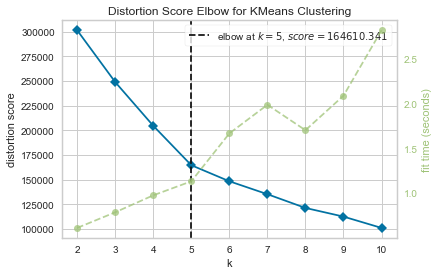

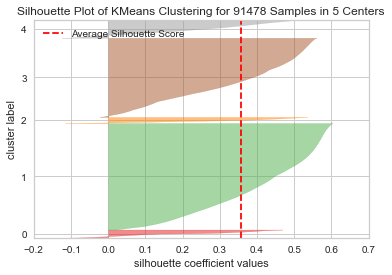

Best silhouette score for Kmeans model is 0.35770879816307455


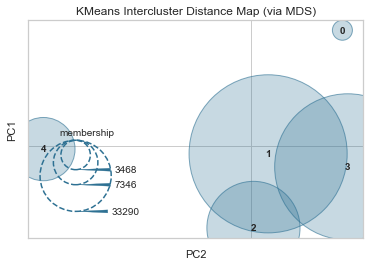

For birch model and 4 clusters score is: -0.08495697386370354
For birch model and 5 clusters score is: -0.08339192344573397
For DBSCAN model and 0.3 eps score is: -0.6108437379659202
For DBSCAN model and 0.4 eps score is: -0.6221103470953924
For DBSCAN model and 0.5 eps score is: -0.6405384262714607
For DBSCAN model and 0.6 eps score is: -0.5841437606004661


In [11]:
X = df.drop(columns=['customer_unique_id'])

preprocessor = preprocessig(X)

clustering = Clustering()
X_labels, best_scores = clustering.fit(X, CLUSTERS)

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


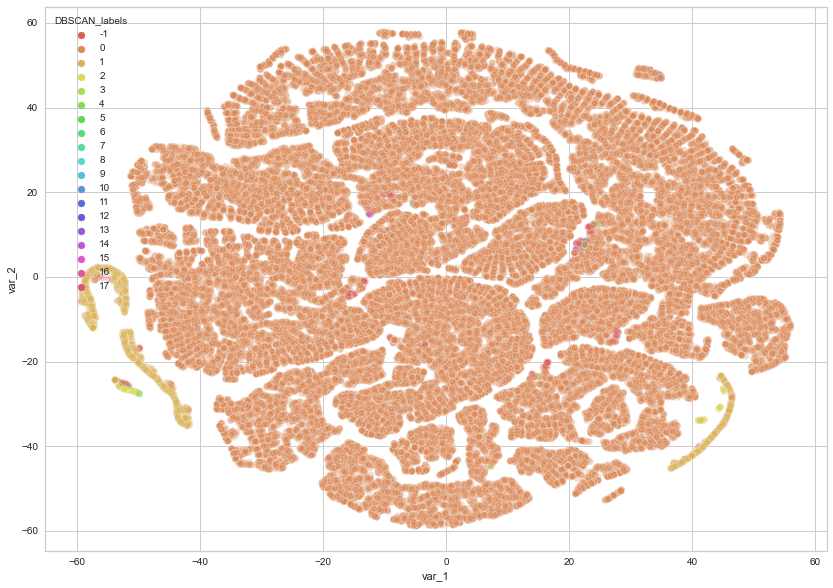

In [38]:
clustering.two_dim_plot(X, X_labels, 'DBSCAN', 'tsne')

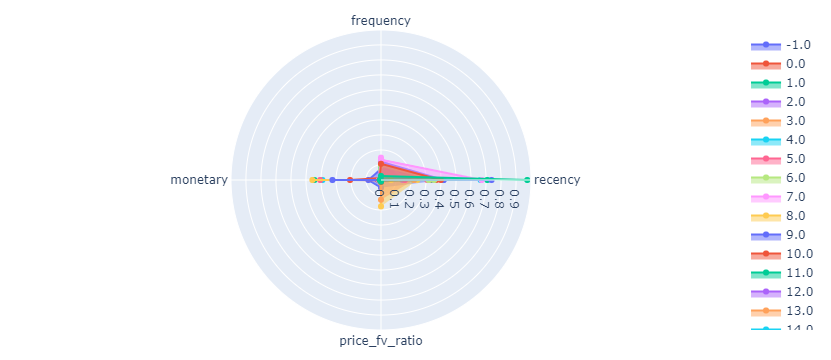

In [12]:
clustering.radar_plot(X, X_labels, 'DBSCAN')

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


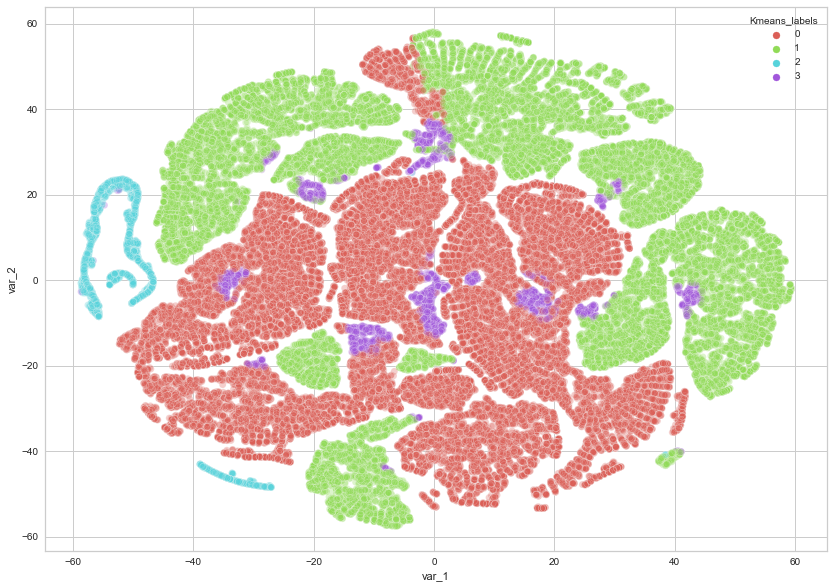

In [39]:
clustering.two_dim_plot(X, X_labels, 'Kmeans', 'tsne')

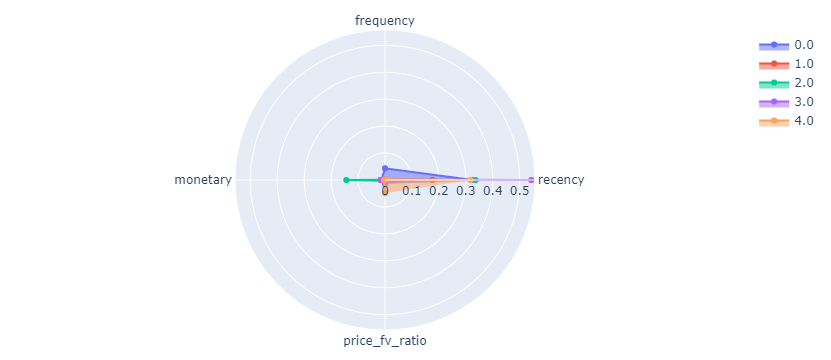

In [13]:
clustering.radar_plot(X, X_labels, 'Kmeans')

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


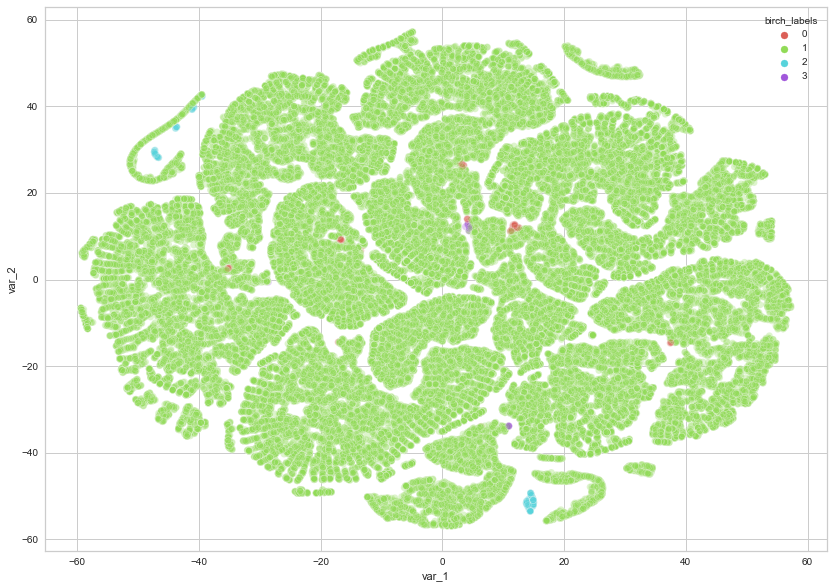

In [40]:
clustering.two_dim_plot(X, X_labels, 'birch', 'tsne')

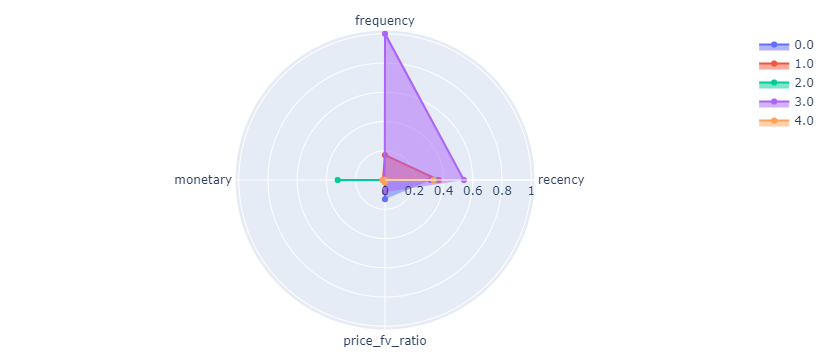

In [14]:
clustering.radar_plot(X, X_labels, 'birch')

## 4. Find best Scalar on RFM data

In [14]:
CLUSTERS = [{'Kmeans': {'model': KMeans, 'min': 0, 'max':0, 'step': 0}}]

ValueError: too many values to unpack (expected 3)

### 4.1 StandardScalar

### 4.2 RobustScalar

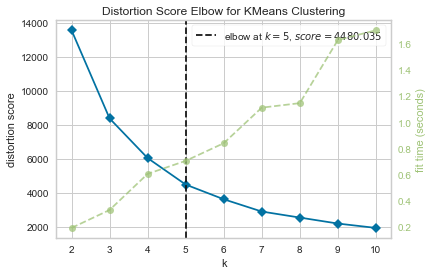

KeyboardInterrupt: 

In [34]:
preprocessor = preprocessig(X)

clustering = Clustering()
X_labels, best_scores = clustering.fit(X, CLUSTERS)

### 4.3 MinMaxScalar

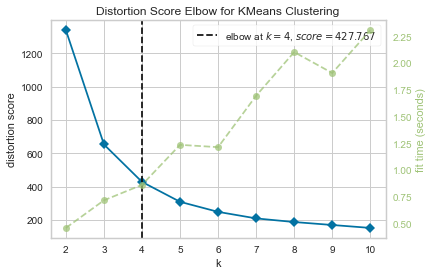

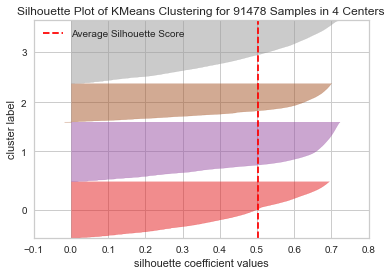

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\manifold\_mds.py:419: UserWarning:

The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.



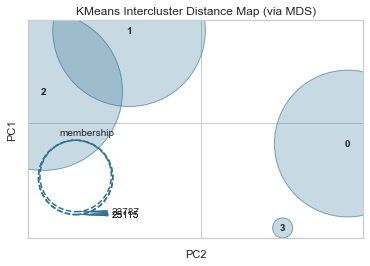

In [43]:
X = df.drop(columns=['customer_unique_id'])

preprocessor = preprocessig(X)

clustering = Clustering()
X_labels, best_scores, pipe = clustering.fit(X, CLUSTERS)

In [44]:
set_config(display='diagram', print_changed_only=True)
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['recency', 'frequency', 'monetary', 'price_fv_ratio'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index([], dtype='object'))])),
                ('silhouettevisualizer',
                 SilhouetteVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 91478 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                                      estimator=KMeans(n_clusters=4)))])

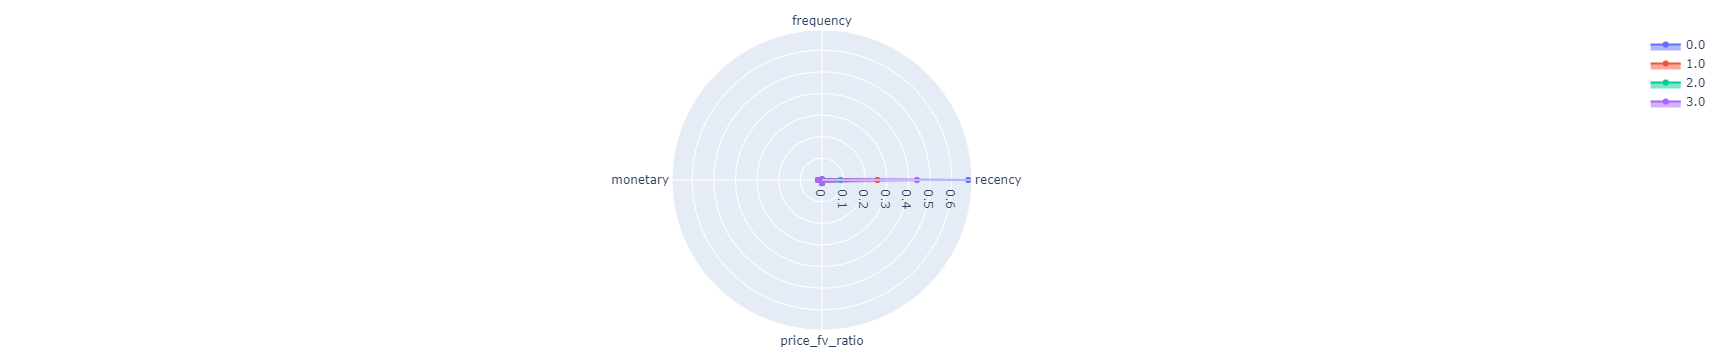

In [62]:
clustering.radar_plot(X, X_labels, 'Kmeans')

## 5. Find best data for clustering

### 5.1 Download data

In [6]:
rfm = pd.read_csv('data/rfm.csv')
satisfaction = pd.read_csv('data/satisfaction.csv')
behavior = pd.read_csv('data/behavior.csv')
geo = pd.read_csv("data/geo.csv")
time = pd.read_csv("data/time.csv")

In [8]:
def merge_df(list_df, merged_df=ids):
    for df in list_df:
        print(merged_df.shape)
        merged_df = merged_df.merge(df,
                                    on='customer_unique_id',
                                    how='left')

    return merged_df.drop(columns=['index'])

### 5.2 All data

(91478, 2)
(91478, 6)
(91478, 7)
(91478, 10)
(91478, 16)


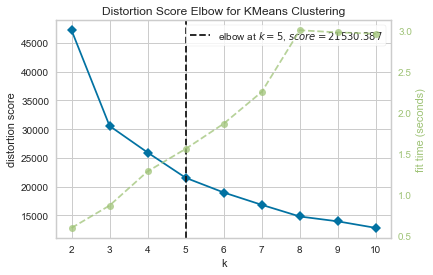

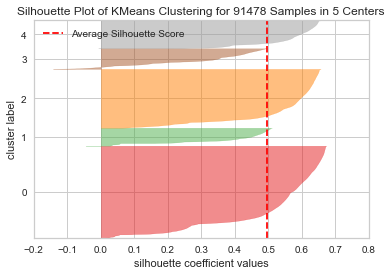

Best silhouette score for Kmeans model is 0.49538021211088107


In [55]:
df = merge_df([rfm, geo, satisfaction, behavior, time])
X = df.drop(columns=['customer_unique_id'])

preprocessor = preprocessig(X)

clustering = Clustering()
X_labels, best_scores = clustering.fit(X, CLUSTERS)

### 5.3 RFM + behavior

(91478, 2)
(91478, 6)


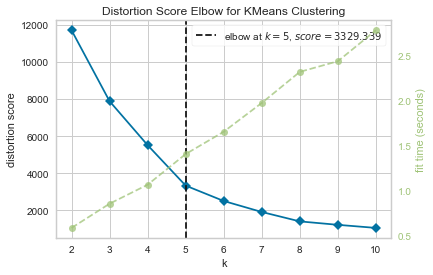

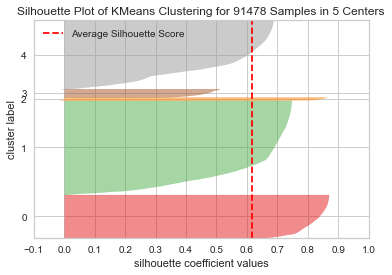

Best silhouette score for Kmeans model is 0.6168172283565617


In [56]:
df = merge_df([rfm, behavior])

X = df.drop(columns=['customer_unique_id'])

preprocessor = preprocessig(X)

clustering = Clustering()
X_labels, best_scores = clustering.fit(X, CLUSTERS)

### 5.4 RFM + satisfaction + time

(91478, 2)
(91478, 6)
(91478, 9)


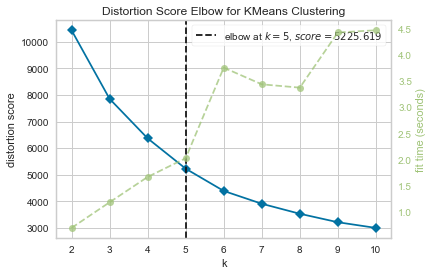

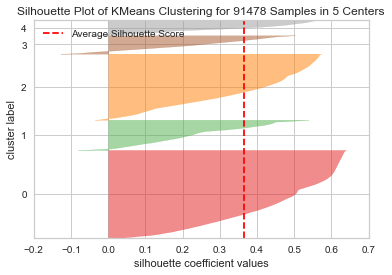

Best silhouette score for Kmeans model is 0.3652976641981142


In [57]:
df = merge_df([rfm, satisfaction, time])
X = df.drop(columns=['customer_unique_id'])

preprocessor = preprocessig(X)

clustering = Clustering()
X_labels, best_scores = clustering.fit(X, CLUSTERS)

### 5.5 RFM + beahavion + time

(91478, 2)
(91478, 6)
(91478, 12)


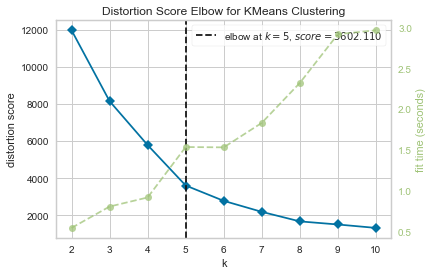

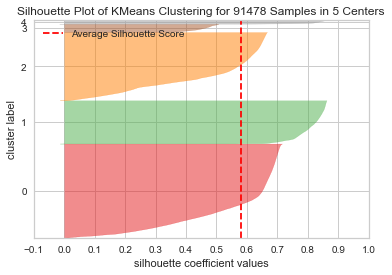

Best silhouette score for Kmeans model is 0.5821798016749085


In [58]:
df = merge_df([rfm, behavior, time])
X = df.drop(columns=['customer_unique_id'])

preprocessor = preprocessig(X)

clustering = Clustering()
X_labels, best_scores = clustering.fit(X, CLUSTERS)

### 5.6 RFM + behavion + geo

(91478, 2)
(91478, 6)
(91478, 9)


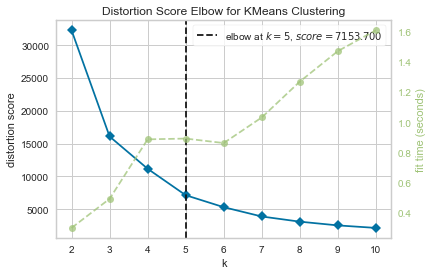

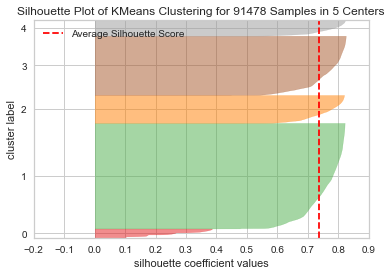

Best silhouette score for Kmeans model is 0.7381532225260425


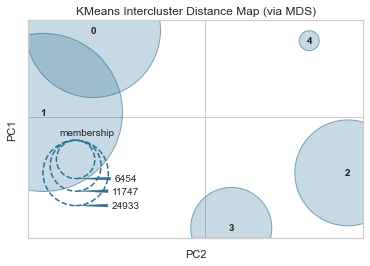

In [57]:
df = merge_df([rfm, behavior, geo])
X = df.drop(columns=['customer_unique_id'])

preprocessor = preprocessig(X)

clustering = Clustering()
X_labels, best_scores = clustering.fit(X, CLUSTERS)

#### 5.6.1 Visualization

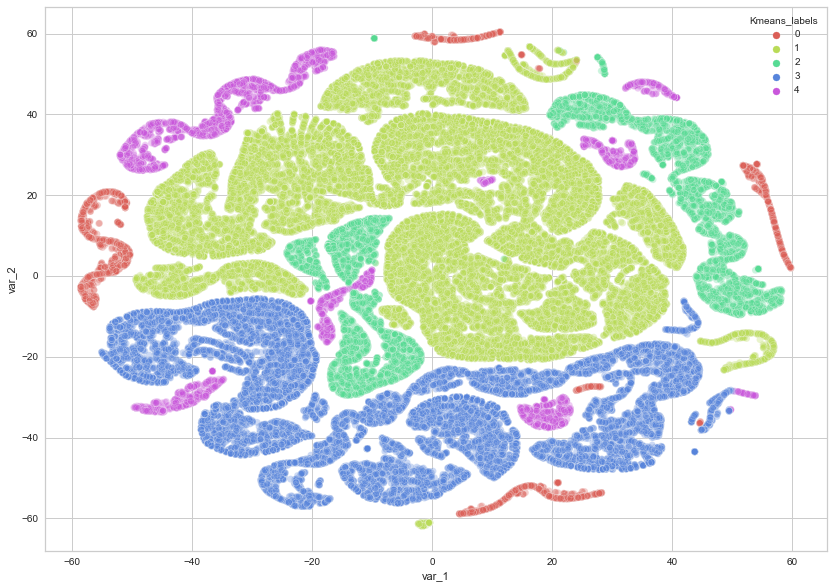

In [73]:
X['payment_type'] = X['payment_type'].astype("category").cat.codes

clustering.two_dim_plot(X, X_labels, 'Kmeans', 'tsne')

#### 5.6.2 Stat for each group

In [50]:
df_in = pd.concat([X, X_labels], axis=1)
numeric_features = df_in.select_dtypes(include=[np.number]).columns
cat_features = df_in.select_dtypes(include=['object']).columns
model_labels = X_labels.filter(like='Kmeans').columns.values[0]

group = df_in.groupby(model_labels)[numeric_features].describe()
insight = group.style.background_gradient(cmap ="RdPu")\
               .set_properties(**{'font-size': '15px'}).format("{:.1f}")
group_cat_fig = df_in.groupby([model_labels, cat_features[0]])[cat_features]\
                     .count()

In [51]:
group_cat_fig

payment_type
Kmeans_labels payment_type              
0             credit_card          44435
1             boleto               11747
2             credit_card          24933
3             boleto                6454
4             debit_card            1415
              voucher               2493

In [46]:
insight.merge(group)

### 5.7 RFM + behavior + geo + time

(91478, 2)
(91478, 6)
(91478, 12)
(91478, 13)
Index([], dtype='object')


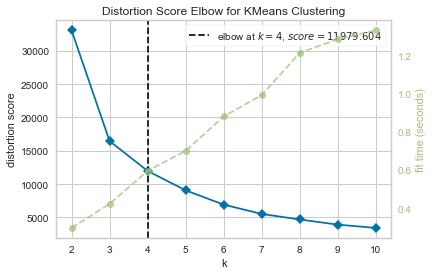

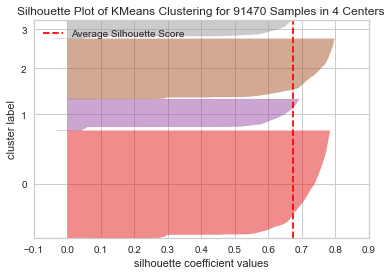

Best silhouette score for Kmeans model is 0.6741639648204271


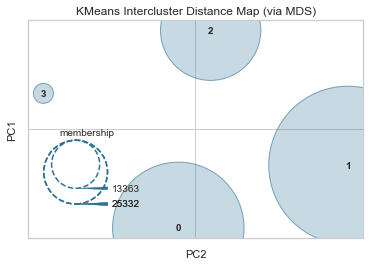

In [29]:
df = merge_df([rfm, behavior, geo, time])

X = df.drop(columns=['customer_unique_id'])
X.dropna(inplace=True)
preprocessor = preprocessig(X)

clustering = Clustering()
X_labels, best_scores = clustering.fit(X, CLUSTERS)

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


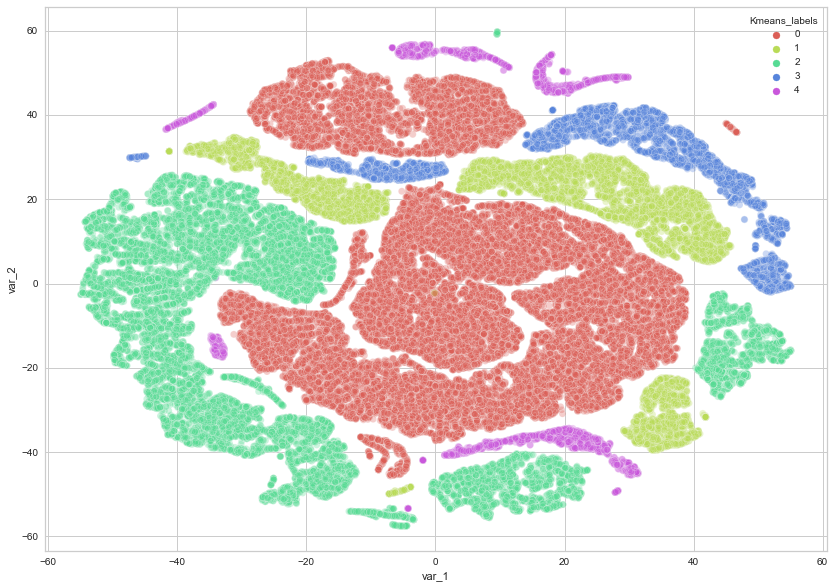

In [21]:
X['payment_type'] = X['payment_type'].astype("category").cat.codes

clustering.two_dim_plot(X, X_labels, 'Kmeans', 'tsne')

In [32]:
df_in = pd.concat([X, X_labels], axis=1)
numeric_features = df_in.select_dtypes(include=[np.number]).columns
cat_features = df_in.select_dtypes(include=['object']).columns
model_labels = X_labels.filter(like='Kmeans').columns.values[0]

group = df_in.groupby(model_labels)[numeric_features].describe()
insight = group.style.background_gradient(cmap ="RdPu")\
               .set_properties(**{'font-size': '15px'}).format("{:.1f}")
group_cat_fig = df_in.groupby([model_labels, cat_features[0]])[cat_features]\
                     .count()
group_cat_fig

payment_type
Kmeans_labels payment_type              
0.0           boleto                8173
              credit_card          34489
              debit_card             619
              voucher               1148
1.0           boleto                3009
              credit_card           8275
              debit_card             185
              voucher                277
2.0           boleto                4691
              credit_card          19250
              debit_card             369
              voucher                615
3.0           boleto                 717
              credit_card           2754
              debit_card             154
              voucher                282
4.0           boleto                1609
              credit_card           4587
              debit_card              86
              voucher                171

In [33]:
insight

### 5.8 RFM + bahavior + satisfaction

(91478, 2)
(91478, 6)
(91478, 8)
Index([], dtype='object')


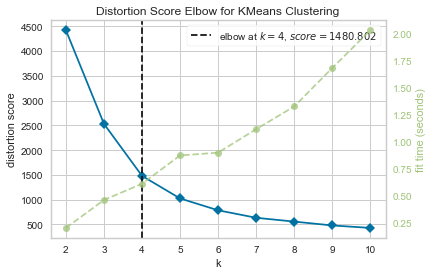

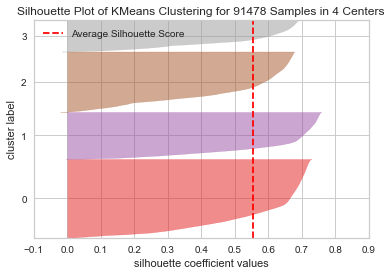

Best silhouette score for Kmeans model is 0.5549829403302082


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\manifold\_mds.py:419: UserWarning:

The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.



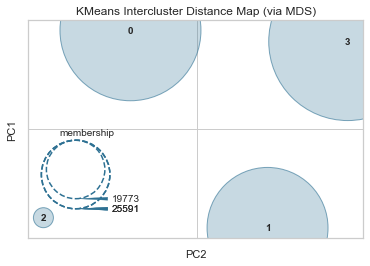

In [64]:
df = merge_df([rfm, time, geo]) 
X = df.drop(columns=['customer_unique_id', 'monetary',
                     'frequency', 'price_fv_ratio'])

preprocessor = preprocessig(X)

clustering = Clustering()
X_labels, best_scores = clustering.fit(X, CLUSTERS)

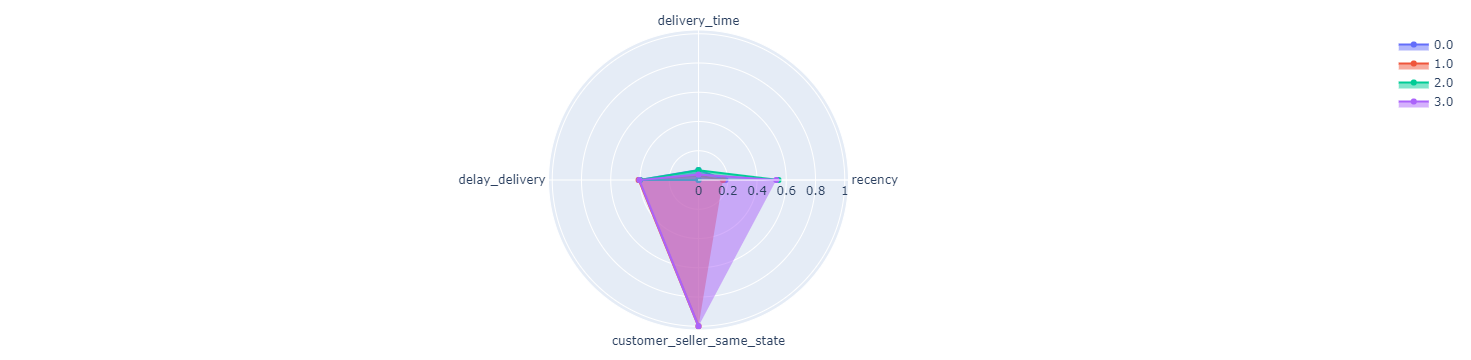

In [65]:
clustering.radar_plot(X, X_labels, 'Kmeans')

In [66]:
clustering.insight(X, X_labels, 'Kmeans')

### 5.9 RFM + geo + time + satosfaction

In [19]:
df = merge_df([rfm, geo, time, satisfaction])

df = df.drop(columns=['review_comment_number'])

Index([], dtype='object')


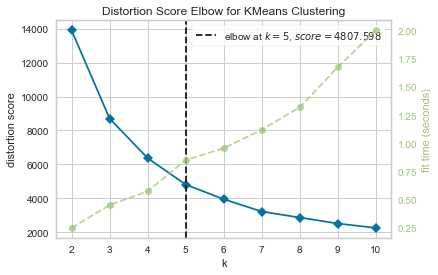

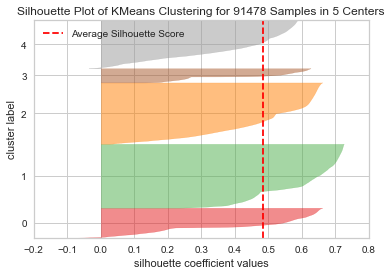

Best silhouette score for Kmeans model is 0.4859361882452534


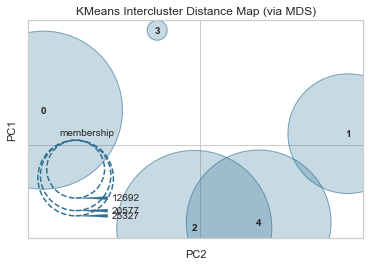

In [31]:
X = df.drop(columns=['customer_unique_id'])

preprocessor = preprocessig(X)

clustering = Clustering()
X_labels, best_scores = clustering.fit(X, CLUSTERS)

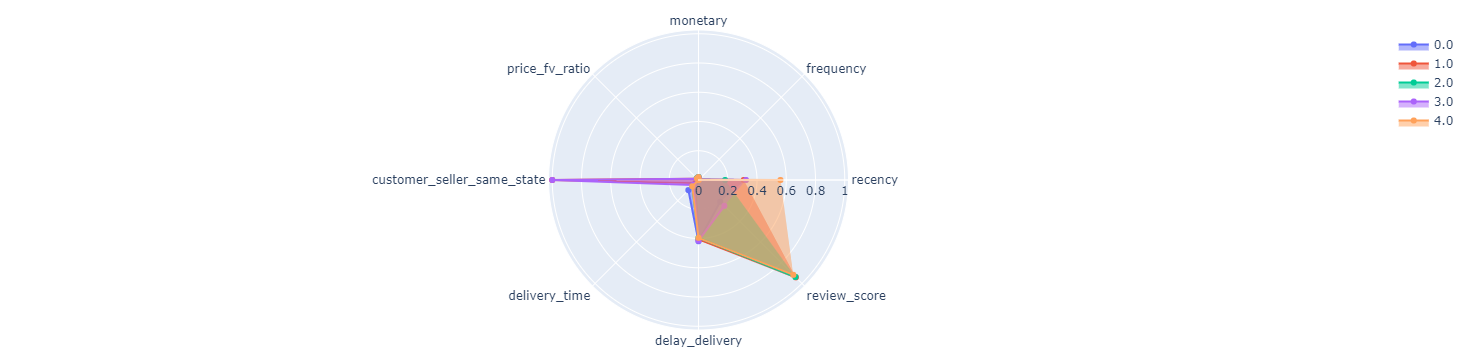

In [32]:
clustering.radar_plot(X, X_labels, 'Kmeans')

In [33]:
clustering.insight(X, X_labels, 'Kmeans')

Index([], dtype='object')


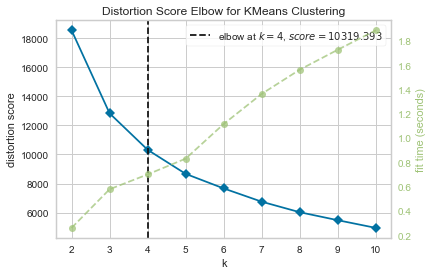

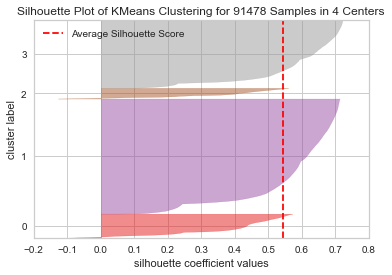

Best silhouette score for Kmeans model is 0.5438356451732399


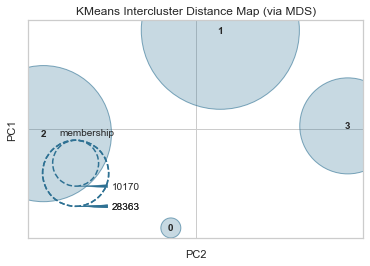

In [54]:
df = df.drop(columns = ['frequency','delay_delivery', 'price_fv_ratio'])
X = df.drop(columns=['customer_unique_id'])

preprocessor = preprocessig(X)

clustering = Clustering()
X_labels, best_scores = clustering.fit(X, CLUSTERS)

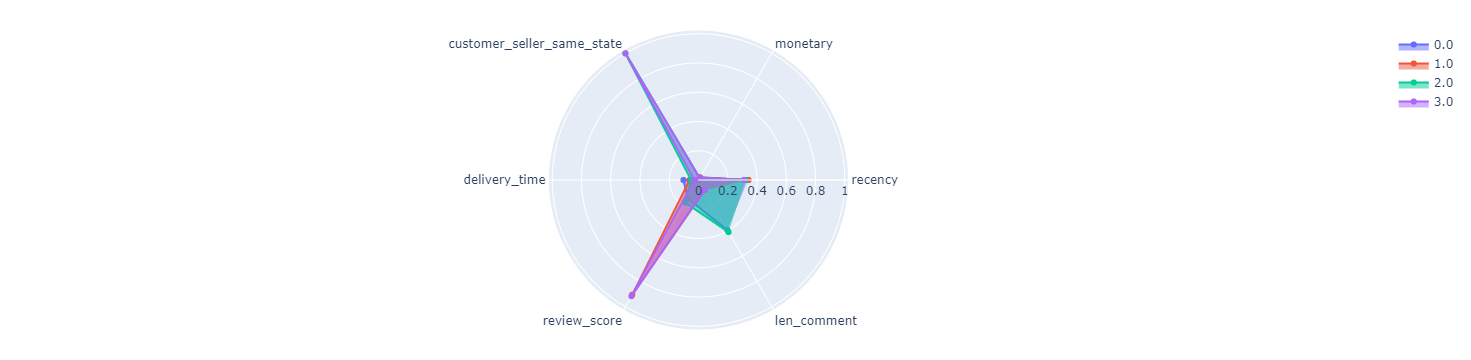

In [55]:
clustering.radar_plot(X, X_labels, 'Kmeans')

In [56]:
clustering.insight(X, X_labels, 'Kmeans')

### 5.10 Final columns

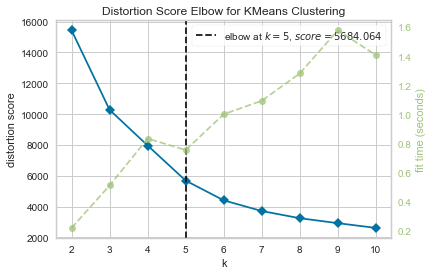

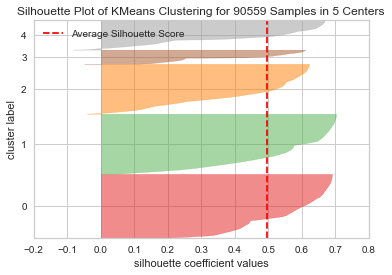

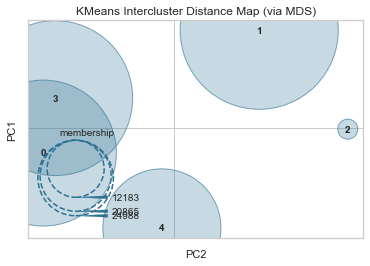

ValueError: too many values to unpack (expected 2)

In [17]:
df = df.drop(columns=['frequency', 'delay_delivery', 'price_fv_ratio',
                      'monetary', 'len_comment', 'delivery_time'])
X = df.drop(columns=['customer_unique_id'])

preprocessor = preprocessig(X)

clustering = Clustering()
X_labels, best_scores = clustering.fit(X, CLUSTERS)

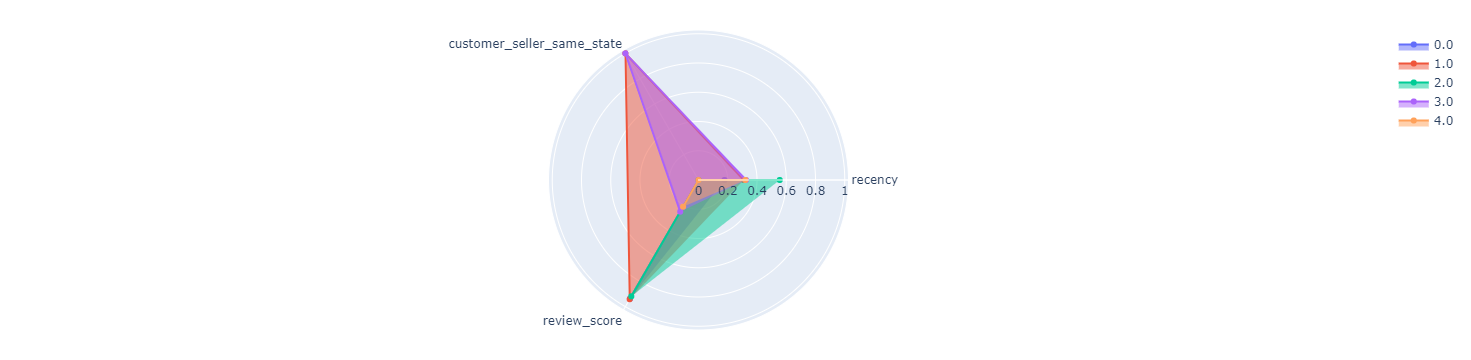

In [73]:
clustering.radar_plot(X, X_labels, 'Kmeans')

In [74]:
clustering.insight(X, X_labels, 'Kmeans')

## 6. Params Tuning on the best model

(91478, 2)
(91478, 6)
(91478, 7)
(91478, 9)
Index([], dtype='object')
100%|██████████████████████████████████████████████| 10/10 [47:57<00:00, 287.73s/trial, best loss: -0.5102057942254878]
KMeans is the best model with a loss of -0.5102057942254878


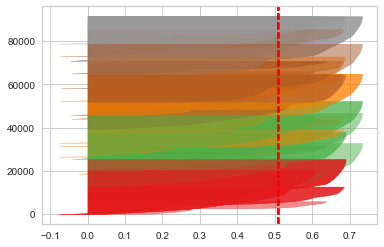

In [16]:
df = merge_df([rfm, geo, time, satisfaction])
df = df.drop(columns=['review_comment_number'])

df = df.drop(columns = ['frequency','delay_delivery', 'price_fv_ratio',
                        'monetary', 'len_comment', 'delivery_time'])
X = df.drop(columns=['customer_unique_id'])

preprocessor = preprocessig(X)

models_params = {KMeans:{'n_clusters': hp.choice("n_clusterd", range(5, 6)),
                         'init': hp.choice("init", ['k-means++', 'random']),
                         'n_init': hp.choice('n_init', range(5, 15, 1)),
                         'max_iter': hp.choice('max_iter', range(150, 450, 450))}}

params = benchmark(models_params, preprocessor)

In [17]:
params

{'init': 'random', 'max_iter': 150, 'n_clusters': 5, 'n_init': 5}

(91478, 2)
(91478, 6)
(91478, 7)
(91478, 9)
Index([], dtype='object')


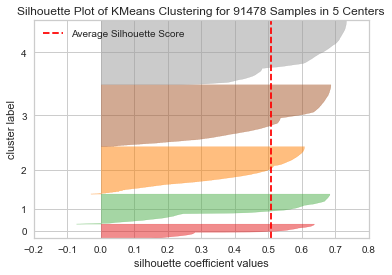

In [18]:
df = merge_df([rfm, geo, time, satisfaction])
df = df.drop(columns=['review_comment_number'])

df = df.drop(columns = ['frequency','delay_delivery',
                        'price_fv_ratio', 'monetary',
                        'len_comment', 'delivery_time'])
X = df.drop(columns=['customer_unique_id'])

preprocessor = preprocessig(X)

kargs = {'init': 'random', 'max_iter': 150, 'n_clusters': 5, 'n_init': 5}

def fit_kmeans(X):
    X_labels = pd.DataFrame()
    silhouette_visualizer = Pipeline([
                            ("preprocessor", preprocessor),
                            ("silhouettevisualizer",
                             SilhouetteVisualizer(KMeans(**kargs)))])

    silhouette_visualizer.fit(X)
    silhouette_visualizer.named_steps['silhouettevisualizer'].show()

    labels = silhouette_visualizer\
        .named_steps['silhouettevisualizer'].labels_
    score = silhouette_visualizer\
        .named_steps['silhouettevisualizer'].silhouette_score_

    X_labels['Kmeans_labels'] = labels
    
    return X_labels

X_labels = fit_kmeans(X)

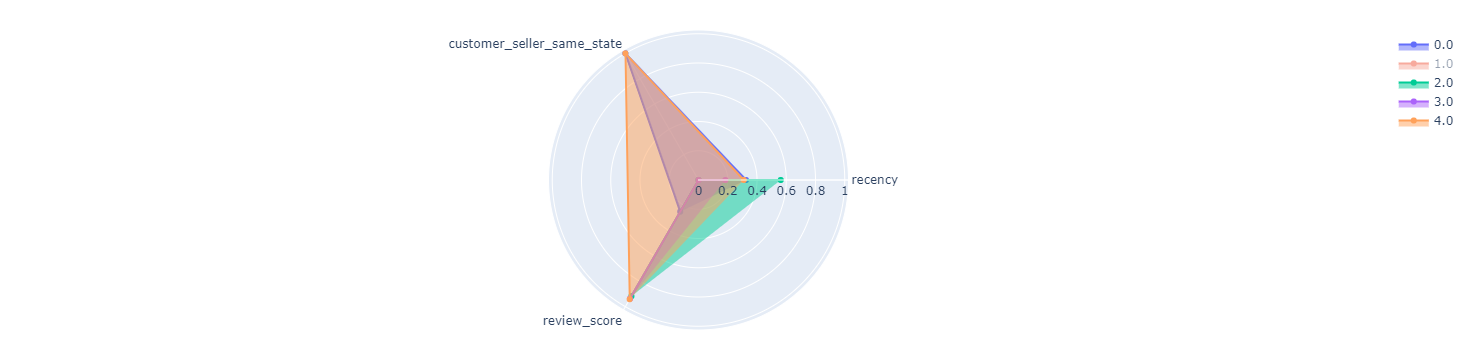

In [19]:
clustering = Clustering()
clustering.radar_plot(X, X_labels, 'Kmeans')

In [11]:
clustering.insight(X, X_labels, 'Kmeans')